
![Translate](translate.jpg)

# Project QT: English to Arabic Translation by Keyword Search


## Jihyun Kim & Gabor Csapo


## Project Description

This project aims to build a prototype of an English to Arabic translation system that receive keywords as input and return full sentence translations. We are using the Basic Travel Expression Corpus (BTEC) database, which contains 20,000 travel-related phrases that are human translated into English, Arabic, and French. By utilizing this high-quality, travel-specific translated phrases, we will focus on implementing a cross-lingual, machine mediated phrase conversation tool by keyword search, rather than implenmenting a statisical or rule-based machine translation system, thus named the Query Translator (QT). This final project will be a starting point of a year-long capstone project to build a fully functional travel translator mobile application.

## Background: Machine Translation

Humans are relational beings. From the very moment of our birth, we exist in relation to others, and we continue to do so for the rest of our lives. And at the very core of these relationships lies communication - we express and receive thoughts, feelings, or ideas. Language has always been an integral part of communication - it is a system on which our verbal interactions are based. However, as as a result of globalization, language has also gained the potential to be an obstacle to communication (Jayaratne, 2003). Increased contact between different ethnicities and cultures have introduced both new possibilities for interaction and new problems for communication. Naturally, as human beings, we have striven to overcome this impediment.

With the advent and rising availability of Machine Translation (MT) tools, we have come one step closer to smooth cross-lingual communication. Although researchers have made significant advancements since then, existing translation models are still incomplete. Challenges remain, especially in achieving high accuracy and speed. There are two main types of machine translation schemes: statistical (SMT) and rule-based (RBMT). For SMT models, the availability and size of the training set strictly limits the accuracy of translation. For RBMT models, the marginal cost of improving the accuracy is very high, as it requires specialized rule-specifications from humans. To solve these two challenges in the context of travel, this research proposes using triangulation and paraphrasing as alternative methods.

The first of the two existing tools we look at for comparison is Google’s translation service, Google Translation, which focuses on translation between more than 10,000 language pairs. It uses Recurrent Neural Networks (RNNs) to directly learn the mapping between an input sequence to an output sequence (Sutskever et al., 2014). Initially, Google had been using the Phrased-Based Machine Translation (PMBT) approach to power its translation service. While the advancement of image and voice recognition tools improved its overall user experience, the service still ran into errors. In September 2016, Google introduced Google Neural Machine Translation system (GNMT), which attempts to address many drawbacks of the previous PMBT approach such as high cost of computation and lack of robustness for practical deployment. The GNMT model consists of a deep Long Short Term Memory (LSTM) network with 8 encoders and 8 decoder layers. Using human-rated, side-by-side comparison as a metric, the GNMT system successfully achieves similar accuracy to that of average bilingual human translators on popular language pairs such as English-Spanish, French-English, etcetera. 

Furthermore, compared to the previous PMBT system, it reduces translation errors by 60% (Wu et al., 2016). While Google Translate has improved greatly in the past year, it focuses on a much wider range of translation. Translation for non-popular language pairs is also still not as accurate. Furthermore, missing a word or two from the sentence significantly skews the translation result, as the GNMT system compares the whole sentence instead of phrases when finding appropriate translation output.

Another translation tool that we compare is iTranslate, which is is a universal app that supports instant voice and text translation on multiple platforms. It is based in Austria and started with improving translation for every European language pair. It is now working towards making more language pairs available. It has unique features such as conversation-like history log and slide-in screen that makes its user interface more suitable for a continuous translated conversation, while Google Translate is better for one-time, high-accuracy, various language pair translation. Nonetheless, iTranslate still lacks the feature of allowing keyword-only input and only supports transliteration between more rare language pairs.

## Problem

Despite the improving accuracy and accessibility of various MT tools, we are still far from a seamless multilingulal conmmunication, especially during travel, due to several reasons such as but not limited to:

1. Accuracy between distant language pairs, especially in unstructured language, is still low.
2. Conversation flow is frequently interupted by translator use eg) typing in a full sentence.
3. Offline access is limited
4. Delivery of translated sentence is also difficult if the user doesn't know how to properly pronounce the translated output or the environment is noisy.

## Our Solution

Our application QT aims to provide a solution to these problems by creating a mobile application that can quickly translate a string of keywords into full sentences. We will organize a storing schema of translated phrases in order to achieve high accuracy. Moreover, we also intend for the translation process to be highly efficient through devising efficient database lookup schemes for the stored information.

This specific segment will focus on how to retrieve the most fitting translation for the user keywords. This Jupyter Notebook is a documentation of how this segment was carried out, following the outline below.


## Project Outline

1. Understanding the corpus
    - Stemming and tokenizing the sentences
    - Constructing a customized stopword list
    - Vectorizing and clustering of sentences
2. Simple implementation of keyword search translation
3. Candidate sentence ranking by measuring sentence similarity

#### Note: Due to copyright issues, Basic Travel Expression Corpus could not to be shared. Only parts of the corpus will be sampled and displayed in this documentation.

## 1. Understanding the corpus

As a part of understanding the corpus, we first read in the English and Arabic BTEC files, organized them into dictionaries, and used the NLTK snowball stemmer to stem all sentences. There was the intial problem of different encoding for Arabic scripts, for which we had to specify utf-8 when reading in the file.

### Reading in the files

In [171]:
# Importing all the essential libraries.
import nltk
from nltk.tokenize import word_tokenize
import re
import os
import codecs
from sklearn import feature_extraction
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [172]:
# Defining a function to parse through the corpus and store every sentence 
# into an empty list.

def corp_to_list(file):
    phr = []
    with open(file, 'r') as f:
        for line in f:
            phr.append(line[:-1])
    return phr

# Defining a function to parse through the corpus and store every sentence
# into an empty dictionary.
# Key is the incremented counter and value is the sentence.

def corp_to_dic(file):
    dic = {}
    counter = 0
    with open(file, 'r') as f:
        for line in f:
            dic[counter] = line[:-1]
            counter += 1
    return dic

In [173]:
# Here we create en_phr and en_dic which both contain sentences from 
# the English version of the corpus.
# Trying to run the same functions on the Arabic corpus has some wrong
# outputs due to its Right-to-Left encoding.

en_phr = corp_to_list('en')
en_dic = corp_to_dic('en')

In [174]:
#Adjusted parsing for Arabic corpus, accounting for the different encoding.
ar_phr = []
ar_dic = {}
counter = 0
with open('clean/ar','r',encoding='utf-8') as arf:
    for line in arf:
        line = line[:-1]
        ar_phr.append(line)
        ar_dic[counter] = line
        counter += 1

In [175]:
#Printing the first 10 phrases to test. The punctuations appear misplaced
# because they are encoded as the usual LTR not RTL.
ar_phr[:10]

['إنها في أخر القاعة . سوف آتي لك ببعض منها الآن . إذا أردت أي شيئاً آخر فقط أعلمني .',
 'لا تقلق من ذلك . سوف آخذها ولن تحتاج إلى لفها .',
 'هل تقومون بعمل تعديلات ؟',
 'الإشارة كانت حمراء .',
 'نريد مائدة بجانب النافذة .',
 'هناك ، أمام بيانات السائح تماما .',
 'لقد التوت أثناء لعبي التنس . شعرت أنها سليمة بعد انتهاء اللعب لكنها اسودت وازرقت بعد ذلك ، هل الأمر خطير ؟',
 'من فضلك ادخل رقم التحديد الشخصي الخاصة بك .',
 'هذه هي أول مرة أمارس فيها الغطس .',
 'لم اسمع بهذا العنوان من قبل بالقرب من هنا .']

In [176]:
#Printing a random element in both dictionaries to crosscheck dict order.
print("Sentence number 10 in Arabic corpus is  " + ar_dic[10])
print("Sentence number 10 in English corpus is  " + en_dic[10])

Sentence number 10 in Arabic corpus is  أشعر بألم شديد هنا .
Sentence number 10 in English corpus is  I have a sore pain here.


### Tokenizing and Stemming the Sentences

Here we use the NLTK Snowball Stemmer to tokenize and stem the sentences for more accurate portrayal of the type of words that are frequently used in this corpus.

In [177]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [178]:
#Defining the tokenize and stem functions
def tokenize_and_stem(text):
    #Tokenizing including the punctuation
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered = []
    #Remove any non-letters
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered.append(token)
    stems = [stemmer.stem(t) for t in filtered]
    return stems

#Defining the same tokenizing function but without stemming the words.
def tokenize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered.append(token)
    return filtered

In [179]:
all_stem = []
all_token = []

for phr in en_phr:
    each_stem = tokenize_and_stem(phr)
    all_stem.extend(each_stem)
    each_token = tokenize(phr)
    all_token.extend(each_token)

In [180]:
token_df = pd.DataFrame({'tokens': all_token})
print('there are ' + str(token_df.shape[0]) + ' items in vocab_frame')

there are 159842 items in vocab_frame


From this analysis, we can see that there are almost 160,000 non-unique tokens. To remove duplicates and aggregate the count of all unique tokens, we created a dataframe as below. It is now narrowed down to 7,152 unique tokens.

In [206]:
# Creating a new dataframe of all unique tokens and their occurence count
unique_tokens = token_df.groupby(token_df.columns.tolist()).size().reset_index().rename(columns={0:'count'})
unique_tokens = unique_tokens.sort_values('count', ascending=False)
unique_tokens = unique_tokens.set_index('tokens')
unique_tokens[:30]

,count
tokens,
i,7920
the,5820
you,5193
a,4888
to,4445
is,3173
please,2775
it,2747
have,2371


Alternatively, we can use the FreqDist method in NLTK to count all unique tokens in our corpus, which shows a little different count than the manually counted version above.

In [190]:
fd = nltk.FreqDist(all_stem)
fd_df = pd.DataFrame(list(fd.items()), columns=['Tokens', 'Count'])
fd_df = fd_df.sort_values('Count', ascending=False).set_index('Tokens')

In [207]:
fd_df[:30]

,Count
Tokens,
i,7920
the,5820
you,5193
a,4888
to,4445
is,3173
pleas,2782
it,2765
have,2405


To visualize the 50 most frequently tokens in the corpus, we created the histogram below.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

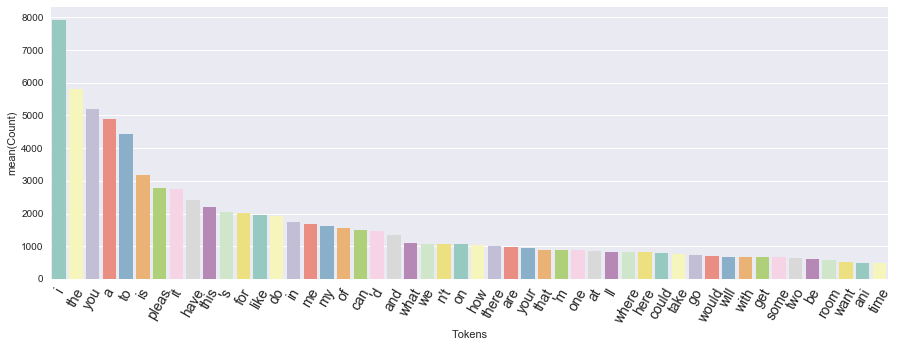

In [15]:
fd_df[:50].plot
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Tokens', y="Count", data=fd_df[:50], palette="Set3")
#plt.setp(ax.get_xticklabels(), rotation=30, fontsize=14)
plt.xticks(rotation=60, fontsize=14)

Plotting the frequency of the top 50 most frequently occuring tokens gives us an insight into what kind of words comprise these sentences. Some observations are:

- Almost all of the top 50 tokens are pronouns, simple verbs, and interrogative words such as where, what, how.
- The only noun in the top 50 is room, which reflects the corpus' nature in travel terminology.

To gain a better insight into the corpus, we looked at n-grams (1,3) and then incorporated custom stopwords to calculate TF-IDF scores for each sentence.

In [213]:
# Making a custom stopwords list
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

stops = set(stopwords)
newstop = [x for x in stops]
newstop.extend(["'s","'m","'d", 'like','sorry','thank','very','please','ca','wo',"n't", "little", "possible"])
stopset = set(newstop)

In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.001,max_features=200000, \
                                   use_idf=True, tokenizer=tokenize_and_stem, \
                                   stop_words=stopset,ngram_range=(1,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(en_phr) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print("There are a total of : "+str(len(terms))+" feature n-grams.")

(19972, 798)
There are a total of : 798 feature n-grams.


In [215]:
terms.sort(key=len, reverse=True)
terms[:20]

['one two three four',
 'excus could tell',
 'one hundr dollar',
 'could recommend',
 'recommend good',
 'two three four',
 'flight number',
 'four five six',
 'long doe take',
 'one two three',
 'san francisco',
 'speak japanes',
 'tomorrow morn',
 'twenti dollar',
 'depart store',
 'fifti dollar',
 'hilton hotel',
 'hundr dollar',
 'make appoint',
 'moment pleas']

Above cell prints the 20 longest n-grams in the corpus. Many of them indicate number values and common question phrases such as "excuse could tell" and "recommend good". This list alone says tells us a lot about the uniqueness of BTEC and its specific focus on travel vocabulary.

### K-means Clustering by Similarity

Now we further explored the sentences by using K-means clustering algorithm to cluster the sentences by their tf-idf matrices. We played around with different number of clusters to see how cluster contexts changed as the number of clusters increased.

One observation from exploring with different number of clusters was that higher number of clusters was more likely to yield clusters fixated on "local optimum" of single words, such as "little", "please", "possible" and so on, rather than "global optimum" of general context.

Displaying of all 20 clusters with 20,000 sentences was difficult, so the top 10 sentences of top 10 clusters are printed as sample.

In [216]:
#define clustering function
def cluster_sentences(sentences, vectorizer, nb_of_clusters):
    #builds a tf-idf matrix for the sentences
    tfidf_matrix = vectorizer.fit_transform(sentences)
    kmeans = KMeans(n_clusters=nb_of_clusters)
    kmeans.fit(tfidf_matrix)
    clusters = collections.defaultdict(list)
    
    for i, label in enumerate(kmeans.labels_):
            clusters[label].append(i)
    return dict(clusters)

In [221]:
nclusters = 20
clusters = cluster_sentences(en_phr, tfidf_vectorizer, nclusters)
for cluster in range(10):
    print("\nCluster ", cluster, ":")
    for i, sentence in enumerate(clusters[cluster]):
        if i < 10:
            print("-", en_phr[sentence])


Cluster  0 :
- How much is the breakfast?
- How much is it to send a registered letter to France?
- How much for a night?
- How much is the service charge?
- I'm afraid that's too much for me.
- How much will it be without a cover?
- There's so much to choose from. What do you think is a good value for my money?
- How much do you charge for processing?
- How much is it in all?
- How much is the price with tax?

Cluster  1 :
- Could you keep this baggage?
- Could you please change my seat?
- Could you tell me how to get to the opera?
- Could you help me find my suitcase?
- Could you spell it?
- Could you please do a make-over for me?
- It's our understanding that you operate various types of shops in Europe. Could you tell me what types you have?
- Could you recommend a picture book for a six-year-old kid?
- Could you keep my valuables, please?
- It's the airlines' fault. Could you arrange another flight, please?

Cluster  2 :
- I don't like the color. Show me another one, please.
- Sh

The short average sentence length made the clustering results vary greatly, but after a few runs, it yielded some very observation into the corpus such as:
- *Cluster 0* pertains to questions asking for price. Many of them were clustered around the phrase "how much" but others were also able to pick up on this price context with phrases such as "too much" and "good value".
- *Cluster 1* is mostly favor asking questions that grouped around "could you".
- *Cluster 4* is about "saying" but in widely varying context.
- *Cluster 6* only contained 1 sentence, which was probably due to its very specific and abnormally long sentence length.
- *Cluster 9* grouped around "number" for phone, flight, pin, and room.

## 2. Simple implementation of keyword search translation

After an in-depth analysis of what BTEC sentences look like, we decided to implement a simple, brute-force search algorithm for matching the user's keywords to candidate sentences. One optimization we took to speed up look up was to differentiate between a query that contained "?" and not. The dictionary containing "?" was smaller than the original, thus speeding up the lookup for questions. This process was however confusing due to Python interpreting Arabic script as Right-to-Left but still interpreting question marks as normal Left-to-Right script.

In [222]:
# English Dictionary containing ID and sentence
# Separate Dictionary only containing questions
endic = {}
q_en_dic = {}
ardic = {}

# Counter variable to keep track of sentence ID
counter = 0
with open('clean/ar','r', encoding='utf-8') as arf:
    for line in arf:
        line = line[:-1]
        ardic[counter] = line
        counter += 1

counter = 0
with open('en', 'r') as f:
    for line in f:
        line = line[:-1]
        endic[counter] = line
        if line[-1] == "?":
            q_en_dic[counter] = line
        counter += 1

In [85]:
# candidate function that takes in the dic and keyword query.
def candidate(dic, query):
    cand = {}
    counter = 0
    onlykey = 0
    for k,v in dic.items():
        # Fastest way to check if a string contained substring
        # was to use set instead of list or string.
        sentset = set(word_tokenize(dic[k].strip().lower()))
        queryset = set(query)
        if queryset.issubset(sentset):
            onlykey = k
            cand[k] = dic[k]
            counter += 1
    # Returns a dictionary and key
    return [cand, onlykey]

In [137]:
# If there is only one sentence containing relevant keyword
# Automatically translates to the sentence
# Otherwise, the user will type in the ID he/she wants translated.
def choice(cand1, only):
    if len(cand1) == 1:
        print("\n--- There was only one match. ---\n")
        print(cand1[only])
        print("\n--- In Arabic ---\n")
        print(ardic[only]+"\n")
            
    elif len(cand1) > 0:
        print("\n--- Choose a sentence among "+ str(len(cand1))+" sentences---\n")
        for k,v in cand1.items():
            print(str(k) + ": " + v)
            print()
        print("\nType in sentence ID: \n")
        choice = int(input())
        print("\n--- Here's your translation ---\n")
        print(ardic[choice]+'\n')
        
    else:
        print("\n--- Sorry, no sentence match for your query. Please try again ---")

In [138]:
# Main function that receives the keyword string as its parameter.
def translate_this(query):
    print("\nWelcome to qt.py!\n")
    query = word_tokenize(query.strip().lower())

    if "?" in query:
        qcand1 = candidate(q_en_dic, query)[0]
        qonly = candidate(q_en_dic, query)[1]
        choice(qcand1, qonly)
    else:
        cand1 = candidate(endic, query)[0]
        only = candidate(endic, query)[1]
        choice(cand1, only)

### Test Run

Below I run some sample keyword queries into the **translate_this** function.

In [92]:
translate_this("how much bus ?")


Welcome to qt.py!


--- Choose a sentence ---

10605: How much is it from Boston to New York by bus?

15933: How much is the bus fare to Boston?


Type in sentence ID: 

10605

--- Here's your translation ---

كم أجرة الحافلة من بوسطن إلى نيويورك ؟



In [94]:
translate_this("friend hit car")


Welcome to qt.py!


--- There was only one match. ---

My friend has been hit by a car.

--- In Arabic ---

صدمت أحد السيارات صديقي .



In [95]:
translate_this("where local food ?")


Welcome to qt.py!


--- There was only one match. ---

Where can I have the best local food?

--- In Arabic ---

أين يمكن أن أجد أفضل طعام محلي ؟



In [28]:
translate_this("how get to station ?")


Welcome to qt.py!


--- Choose a sentence ---

17408: Excuse me, how can I get to the station?

3282: How do I get back to Charing Cross Station?

17066: How long does it take to get to the station by taxi?

18795: How do I get to the station?

1356: How many minutes does it take to get to the station by taxi?

15722: Excuse me. Could you tell me how to get to the station?


Type in sentence ID: 

17408

--- Here's your translation ---

معذرة كيف أذهب إلى المحطة ؟



## 3. Candidate Sentence Filtering Using Jaccard Similarity

From the output of **translate_this("how get to station ?")**, we can see that BTEC contains multiple sentences of the same meaning. To optimize the lookup speed, we can try removing duplicates so that we don't have to iterate through as many sentences when doing the search.

#### Jaccard Similarity Index


As a way to evaluate "similarity" between query and candidate sentence, we used Jaccard Similarity Index on tokenized and stemmed input. Jaccard Index was chosen over other methods because it can be given the proximity of the two data sets efficiently without the use of data redundancy (Niwattanakul, 2013). The threshold is set to 50%, which means that if more than 50% of the tokens match between the two strings, it will evaluate to True (i.e. similar).

In [228]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet
from nltk import pos_tag
import string

# POS tagging using Wordnet
def get_wordnet_pos(pos_tag):
    if pos_tag[1].startswith('J'):
        return (pos_tag[0], wordnet.ADJ)
    elif pos_tag[1].startswith('V'):
        return (pos_tag[0], wordnet.VERB)
    elif pos_tag[1].startswith('N'):
        return (pos_tag[0], wordnet.NOUN)
    elif pos_tag[1].startswith('R'):
        return (pos_tag[0], wordnet.ADV)
    else :
        return (pos_tag[0], wordnet.NOUN)
    
# Create tokenizer and stemmer
tokenizer = WordPunctTokenizer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def jaccard_similar(a, b, threshold):
    pos_a = map(get_wordnet_pos, pos_tag(tokenizer.tokenize(a)))
    pos_b = map(get_wordnet_pos, pos_tag(tokenizer.tokenize(b)))
    
    lemmae_a = [lemmatizer.lemmatize(token.lower().strip(string.punctuation), pos) for token, pos in pos_a\
      if pos == wordnet.NOUN and token.lower().strip(string.punctuation) not in stopset]
    lemmae_b = [lemmatizer.lemmatize(token.lower().strip(string.punctuation), pos) for token, pos in pos_b\
      if pos == wordnet.NOUN and token.lower().strip(string.punctuation) not in stopset]
    
    # Jaccard similarity
    ratio = len(set(lemmae_a).intersection(lemmae_b)) / float(len(set(lemmae_a).union(lemmae_b)))
    return (ratio >= threshold)

#### Test run of Jaccard Similarity

Using candiate sentences from **translate_this("how get to station ?")**

In [152]:
station1 = 'How many minutes does it take to get to the station by taxi?'
station2 = 'how get to station ?'
jaccard_similar(station1, station2, 0.5)

False

In [151]:
station1 = 'How do I get to the station?'
station2 = 'how get to station ?'
jaccard_similar(station1, station2, 0.5)

True

In [153]:
station1 = 'how get to station ?'
station2 = 'How do I get back to Charing Cross Station?'
jaccard_similar(station1, station2, 0.5)

False

### Updating the originial candidate search function

We can now update the original candidate search function using this Jaccard Similarity filtering. By incorporating this extra filter that decides if a candidate sentence is a "close enough" match or not, we can narrow down the options so that the user can choose from a more curated selection of sentences to translate.

In [226]:
# Updated candidate function that checks if the sentence is more than 50% similar to the user's keywords.
def jac_candidate(dic, query):
    cand = {}
    counter = 0
    onlykey = 0
    for k,v in dic.items():
        sentset = set(word_tokenize(dic[k].strip().lower()))
        queryset = set(word_tokenize(query.strip().lower()))
        if queryset.issubset(sentset):
            if jaccard_similar(dic[k], query, 0.5):
                onlykey = k
                cand[k] = dic[k]
                counter += 1
    return [cand, onlykey]

In [227]:
def jac_translate_this(query):
    print("\nWelcome to qt.py!\n")

    if "?" in query:
        qcand1 = jac_candidate(q_en_dic, query)[0]
        qonly = jac_candidate(q_en_dic, query)[1]
        choice(qcand1, qonly)
    else:
        cand1 = jac_candidate(endic, query)[0]
        only = jac_candidate(endic, query)[1]
        choice(cand1, only)

#### Test run of the updated search function

Using candiate sentences from **translate_this("how get to station ?")**

In [156]:
jac_translate_this('how get to station ?')


Welcome to qt.py!


--- There was only one match. ---

How do I get to the station?

--- In Arabic ---

كيف أصل إلى المحطة ؟



#### Side-by-side comparison for "recommend good restaurant ?"

Below code shows a direct comparison of the candidate sentences yielded from the old search function and Jaccard search function. When using query "recommend good restaurant ?" we can see that no filtering returns 7 candidate sentences while sentence similarity filtering yields 5 more accurate matches.


In [159]:
translate_this('recommend good restaurant ?')


Welcome to qt.py!


--- Choose a sentence among 7 sentences---

12882: Excuse me. Would you recommend a good restaurant in this hotel?

4117: Could you recommend a good restaurant?

12616: Can you recommend a good restaurant near here?

7724: Could you recommend a good restaurant near here?

1149: Could you recommend a good French restaurant?

10974: Could you recommend a good, inexpensive restaurant near this hotel?

14581: Would you please recommend a good restaurant?


Type in sentence ID: 

1149

--- Here's your translation ---

هل لك أن تقترح مطعماُ فرنسياً جيداً ؟



In [161]:
jac_translate_this('recommend good restaurant ?')


Welcome to qt.py!


--- Choose a sentence among 5 sentences---

12616: Can you recommend a good restaurant near here?

14581: Would you please recommend a good restaurant?

7724: Could you recommend a good restaurant near here?

1149: Could you recommend a good French restaurant?

4117: Could you recommend a good restaurant?


Type in sentence ID: 

4117

--- Here's your translation ---

هل لك أن تزكي لي مطعما جيدا ؟



## Conclusion

Throughout this notebook, we looked at:

1. Corpus analysis
2. Simple search
3. Optimization of search using Jaccard Similarity Index

This is a starting point for implementing a much more robust search algorithm for English-Arabic phrasal conversation system. There is a wide range of possible optimizations that this project can take, including:

- Gender and age specification
- Removal of duplicates in the corpus
- Changing named entities to variables that can be dynamically replaced
- Improving lookup speed



## Bibliography

Jayaratne, N. (2002). U.S. Patent Application No. 10/081,773.

Niwattanakul, S., Singthongchai, J., Naenudorn, E., & Wanapu, S. (2013, March). Using of Jaccard coefficient for keywords similarity. In Proceedings of the International MultiConference of Engineers and Computer Scientists (Vol. 1, p. 6).

Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. In Advances in neural information processing systems (pp. 3104-3112).

Wu, Y., Schuster, M., Chen, Z., Le, Q. V., Norouzi, M., Macherey, W., ... & Klingner, J. (2016). Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation. arXiv preprint arXiv:1609.08144.